# Convolutional Networks
This script demos using spatial convolutional neural networks to build a supervised classifier for the crop labels using the input temporal images as features and also compares them against other classifiers.

In [1]:
! pip install tqdm
! conda install -c conda-forge rtree --yes

     |████████████████████████████████| 61kB 1.4MB/s eta 0:00:011
You should consider upgrading via the 'pip install --upgrade pip' command.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/tensorflow_p36

  added / updated specs: 
    - rtree


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    cryptography-2.8           |   py36h45558ae_2         628 KB  conda-forge
    pycurl-7.43.0.5            |   py36h16ce93b_0          69 KB  conda-forge
    pykerberos-1.2.1           |   py36h2afdebe_2          27 KB  conda-forge
    libspatialindex-1.9.3      |       he1b5a44_3         3.1 MB

In [2]:
from pylab import *

from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, concatenate, Input, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend 
import numpy as np
import common, preprocess
import tqdm, rtree

Using TensorFlow backend.


Because training a conv net can be computationally expensive, we're going to start with the previously selected features.

In [3]:
labels = common.loadNumpy('labels')
keyBands = preprocess.getKeyFeatures()

100%|██████████| 10/10 [01:22<00:00,  8.29s/it]


## Sampling considerations
Before we can build our conv net we need to appropriately sample the data.  Because we are using spatial conv nets, and not 1D conv nets over the temporal axis, we need to take into account the significant amount of spatial auto correlation in the data.  A naive random sampling approach, will show that the train/test scores are almost the same, because essentially there will be no truly held out data, because some of the training data is virtually guaranteed to come from every part of the image.  

To correctly hold out some data, we need to divide the image into either strips or chunks that represent groups that are held out. This allows us to most closely emulate the process of training a model on some subset of spatial data and then applying it to a completely unseen area. I choose to hold out large rectangular tiles from the image.  In each case, all of the tiles are entirely self-contained, no data leakage from nearby tiles is allowed.

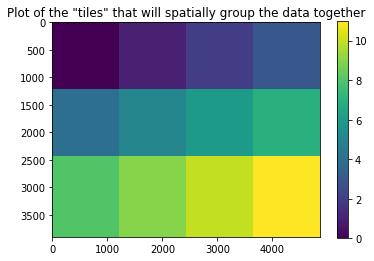

In [4]:
h,w = labels.shape
groups = np.zeros((h,w),dtype='uint8')
groupSize = max(h//4,w//4)
group = 0
groupRTree = rtree.index.Index()
groupMap = {}
for i in range(0, h, groupSize):
    for j in range(0,w,groupSize):
        
        si,ei = i, i+groupSize
        sj, ej = j, j+groupSize
        
        if ei > h:
            continue
        if ej > w: 
            continue
        
        if (i+2*groupSize) > h:
            ei = h
        if (j+2*groupSize) > w:
            ej = w
        
        groups[si:ei,sj:ej] = group
        groupRTree.insert(group,(sj,si,ej,ei))
        groupMap[group] = (si,ei,sj,ej)
#         print(i,j,group)
        group+=1

figure()
title('Plot of the "tiles" that will spatially group the data together')
imshow(groups)
colorbar()

In the above image, there are 12 groups.  For our tests, we will hold out all of the data from one or more tiles at once, and use the remaining tiles to train the model.  Because selecting which tiles to hold out is a potential source of bias, we will train in a cross-validation mode where we repeatedly train models on different subsets of the data by changing which tiles we are holding out.  This will not allow us to say that we have a single model that performs best, but it will enable us to say in general this is how well we would expect a model trained this way to perform on totally unseen data, while removing the selection bias.

In [5]:
h,w = labels.shape
featureArray = np.zeros((h,w,len(keyBands)))
for k, key in enumerate(keyBands):
    featureArray[:,:,k] = keyBands[key]

there are n classes 10


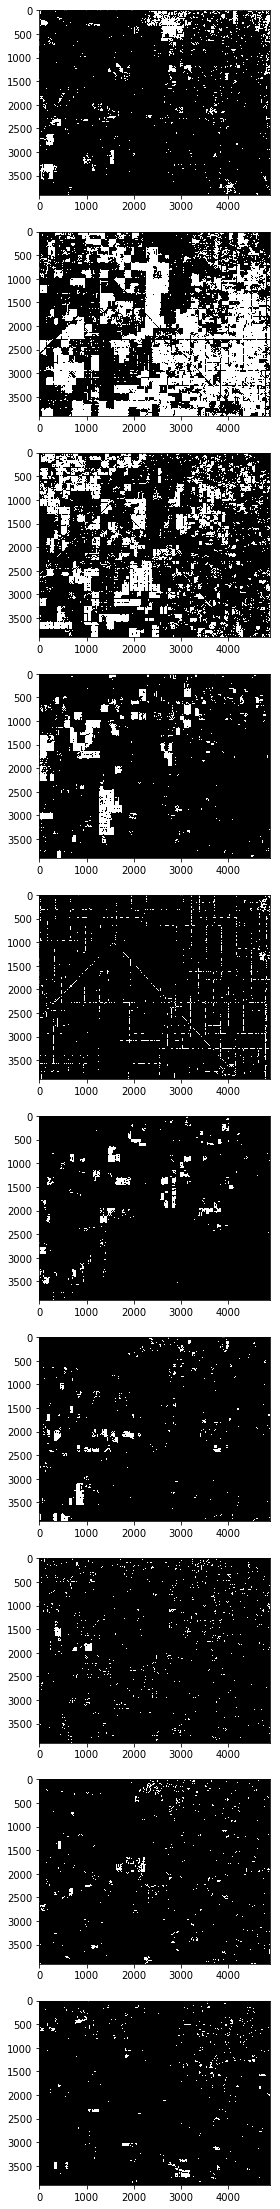

In [6]:
nclasses=int(labels.max())
print('there are n classes', nclasses)
# we need to use one hot labeling encoding for our labels
one_hot_labels = np.zeros((h,w,nclasses),dtype='f4')

figure(figsize=(40,40))
for k in range(nclasses):
    mask = labels == k
    im_ones = np.zeros_like(labels)
    im_ones[mask] = 1
    one_hot_labels[:,:,k] = im_ones
    subplot(10,1,k+1)
    imshow(im_ones,cmap='gray',vmax=1.0)

In [7]:
featureArray.shape

(3902, 4873, 20)

Now we load the data, and format it for our convolutional neural network. Our conv net will take 3d tiles of size 64x64x20 where 64x64 is the spatial dimension, and 20 is the number of features. I chose 64x64 because it gives us enough context to say what is going on nearby without making it so large that it becomes problematic to train the model.  Because the tile shape does not evenly divide into the grouping shape, we have to be careful to ensure that we're not gathering data from outside of our group.

In [8]:
tileHeight = 64
tileWidth = 64
tiles = []
ytiles = []
tileGroups = []
tileInfo = {}

tileIndex = 0
for ty in range(0, h, tileHeight):
    for tx in range(0, w, tileWidth):
        sy = ty
        sx = tx
        ey = sy+tileHeight
        ex = sx+tileWidth
        groups = list(groupRTree.intersection((sx,sy,ex,ey)))
        # if we span more than one group, then we need to make two tiles
        # one for each group, but that is limited to each groups visible data
        # this prevents data leakage from one group to the next .
        for group in groups:
            gsy,gey, gsx,gex = groupMap[group]
            if ey > gey:
                sy = gey-tileHeight
                ey = gey
            elif sy < gsy:
                sy = gsy
                ey = gsy + tileHeight
                
            if ex > gex:
                sx = gex-tileWidth
                ex = gex
            elif sx < gsx:
                sx = gsx
                ex = gsx+tileWidth
                
            assert ex-sx == tileWidth
            assert ey-sy == tileHeight
            tileInfo[tileIndex] = (sy,ey,sx,ex, group)

            tiles.append(featureArray[sy:ey,sx:ex])
            ytiles.append(one_hot_labels[sy:ey,sx:ex])
            tileGroups.append(group)

            tileIndex+=1
        

In [9]:
tileArray = np.array(tiles)
yTileArray = np.array(ytiles)
groupArray = np.array(tileGroups)
del tiles
del ytiles


In [10]:
tileArray.shape, yTileArray.shape, groupArray.shape

((5040, 64, 64, 20), (5040, 64, 64, 10), (5040,))

In [11]:
from sklearn.model_selection import LeavePGroupsOut

Here's an example that shows how using the groups with the tiles will automatically break up the data for us.

In [12]:
lpo = LeavePGroupsOut(4)
print('n splits', lpo.get_n_splits(tileArray,yTileArray,groupArray))

n splits 495


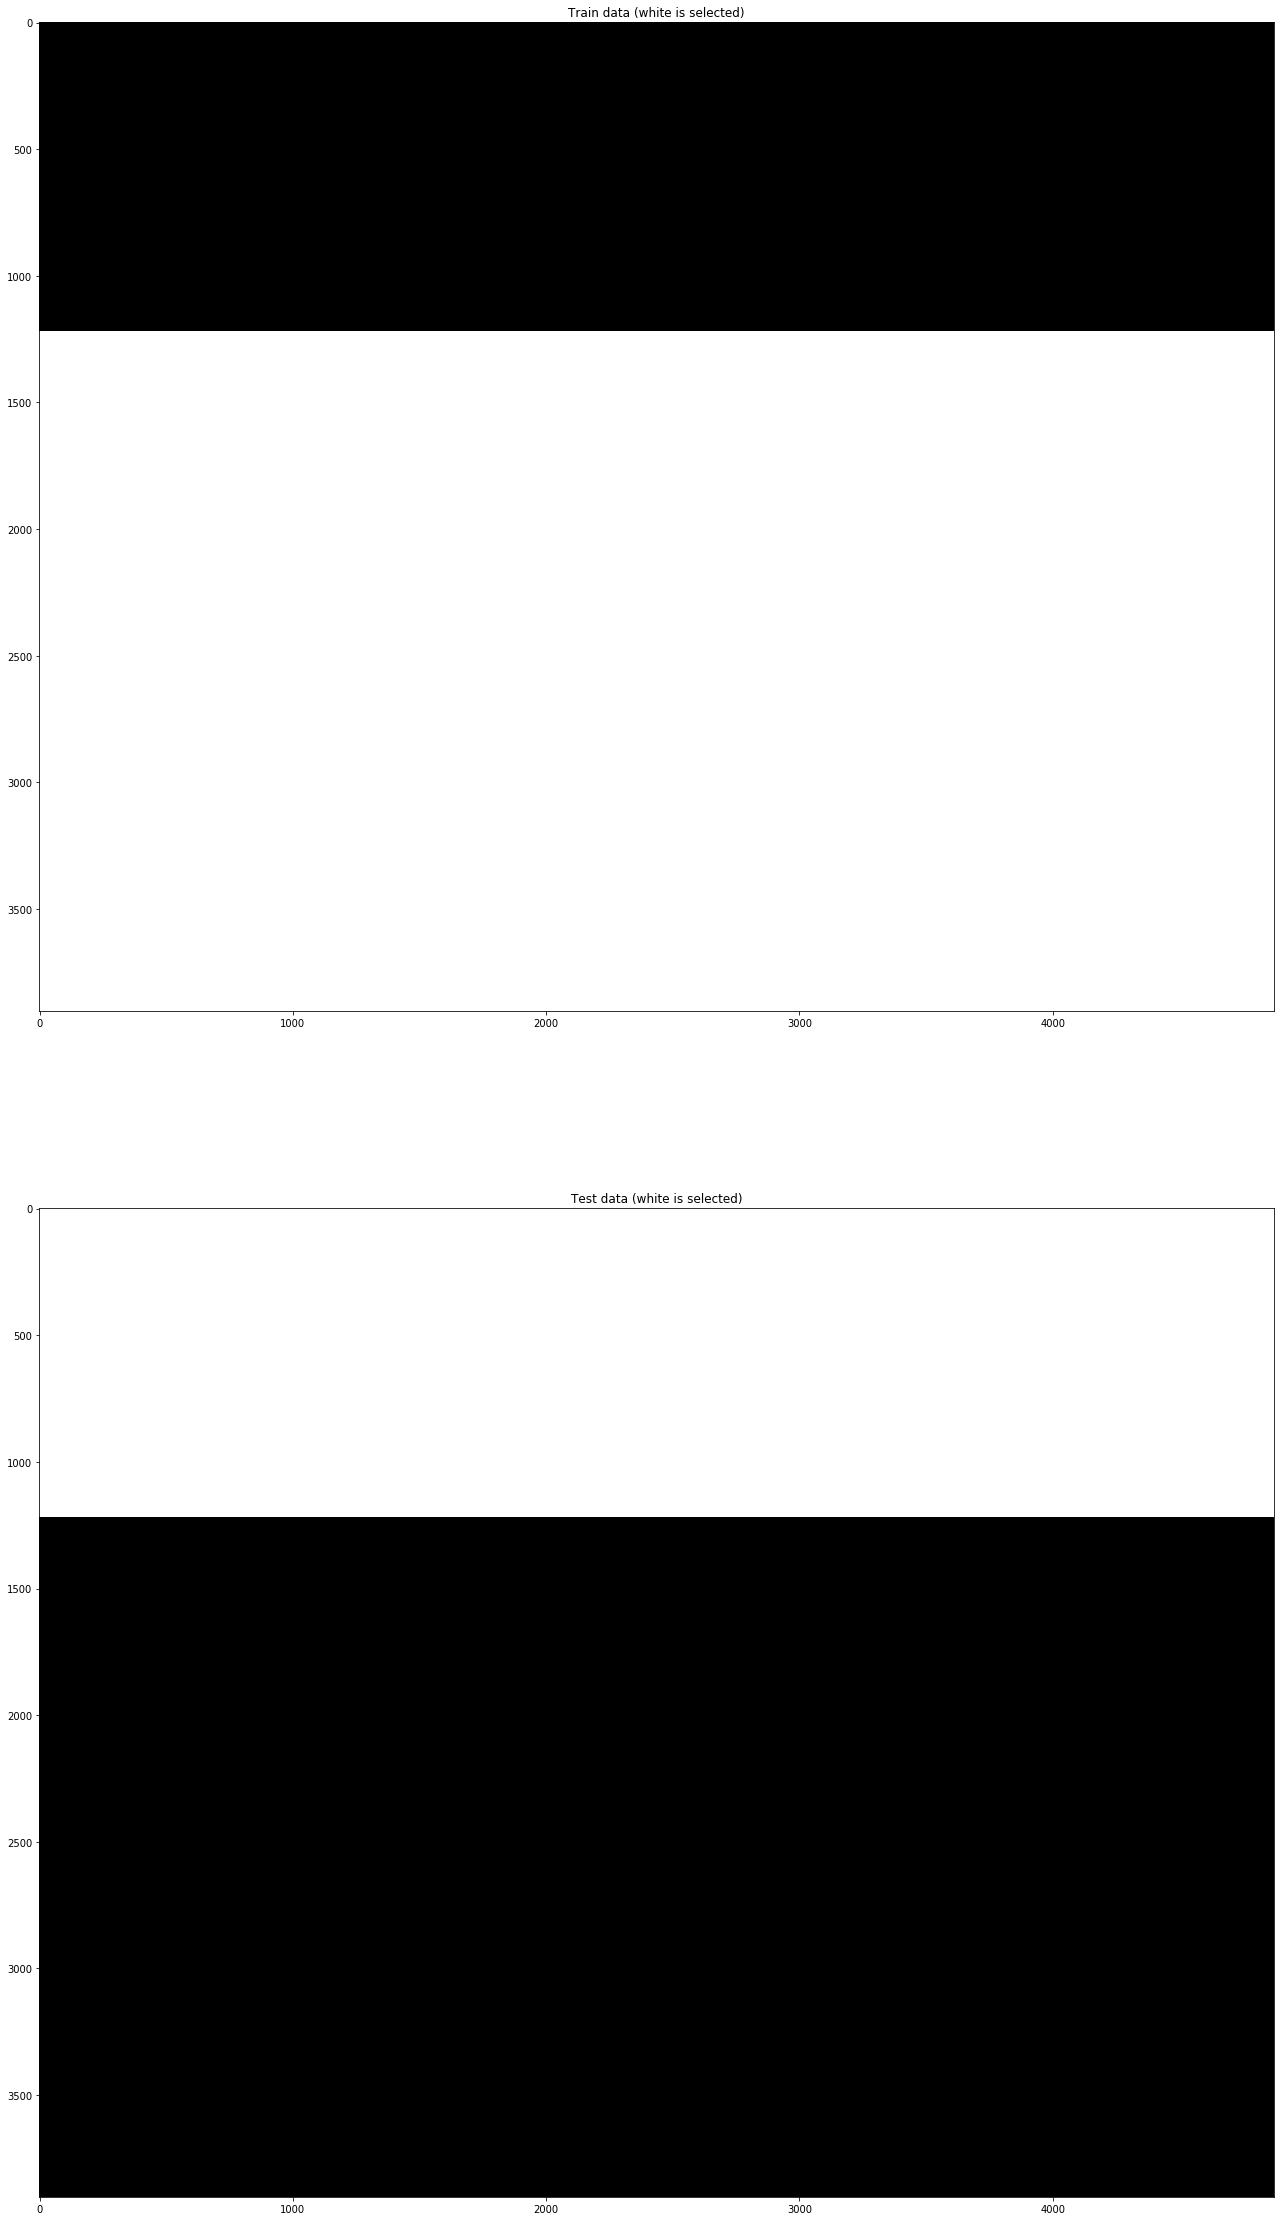

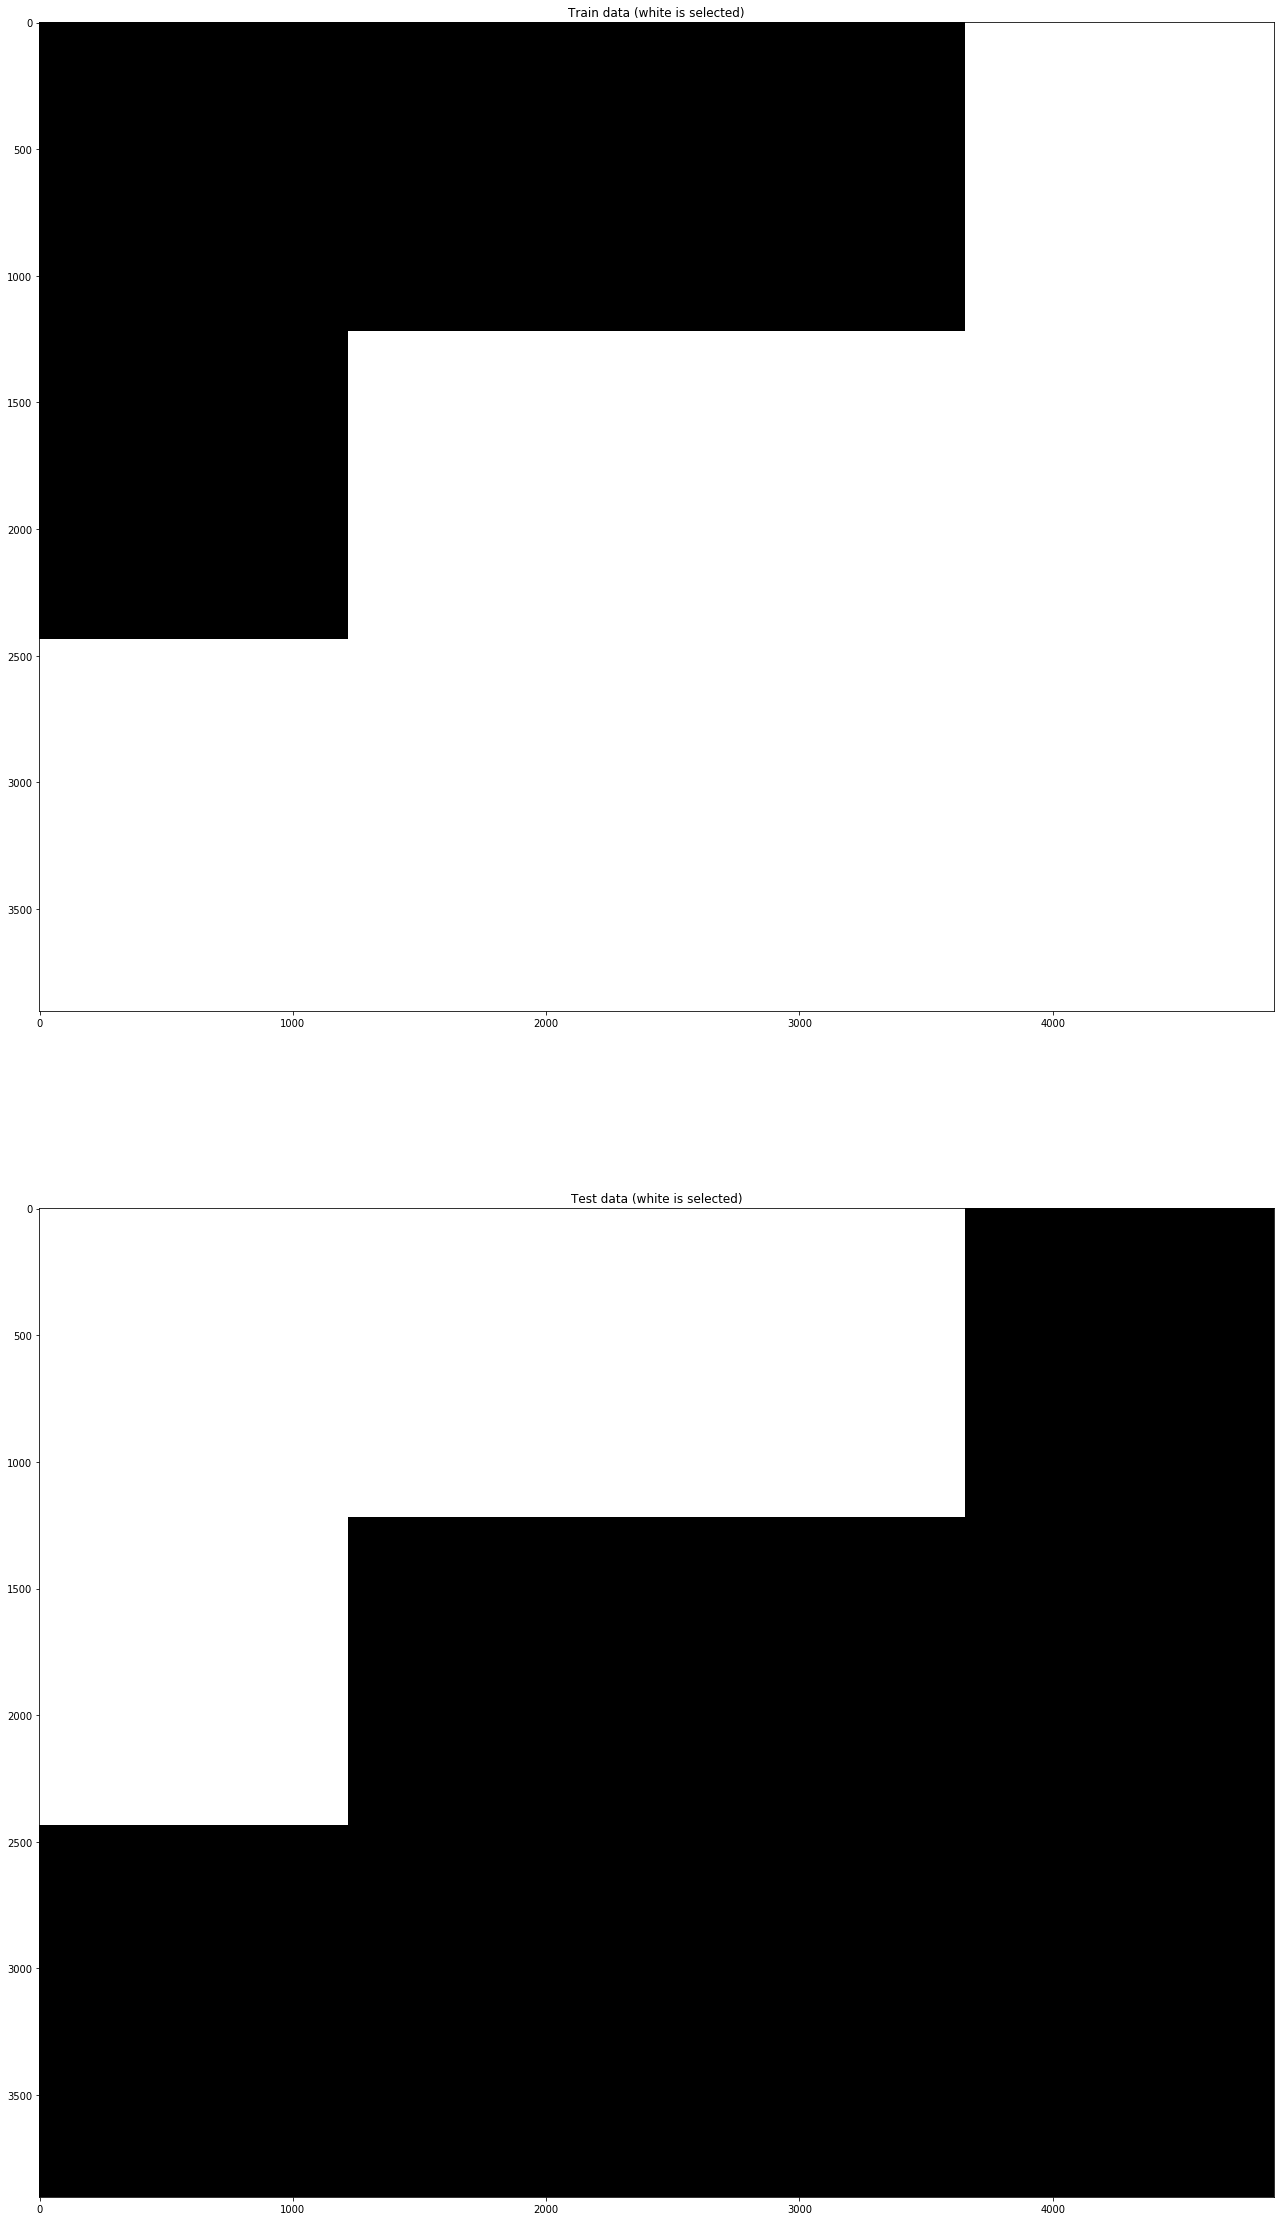

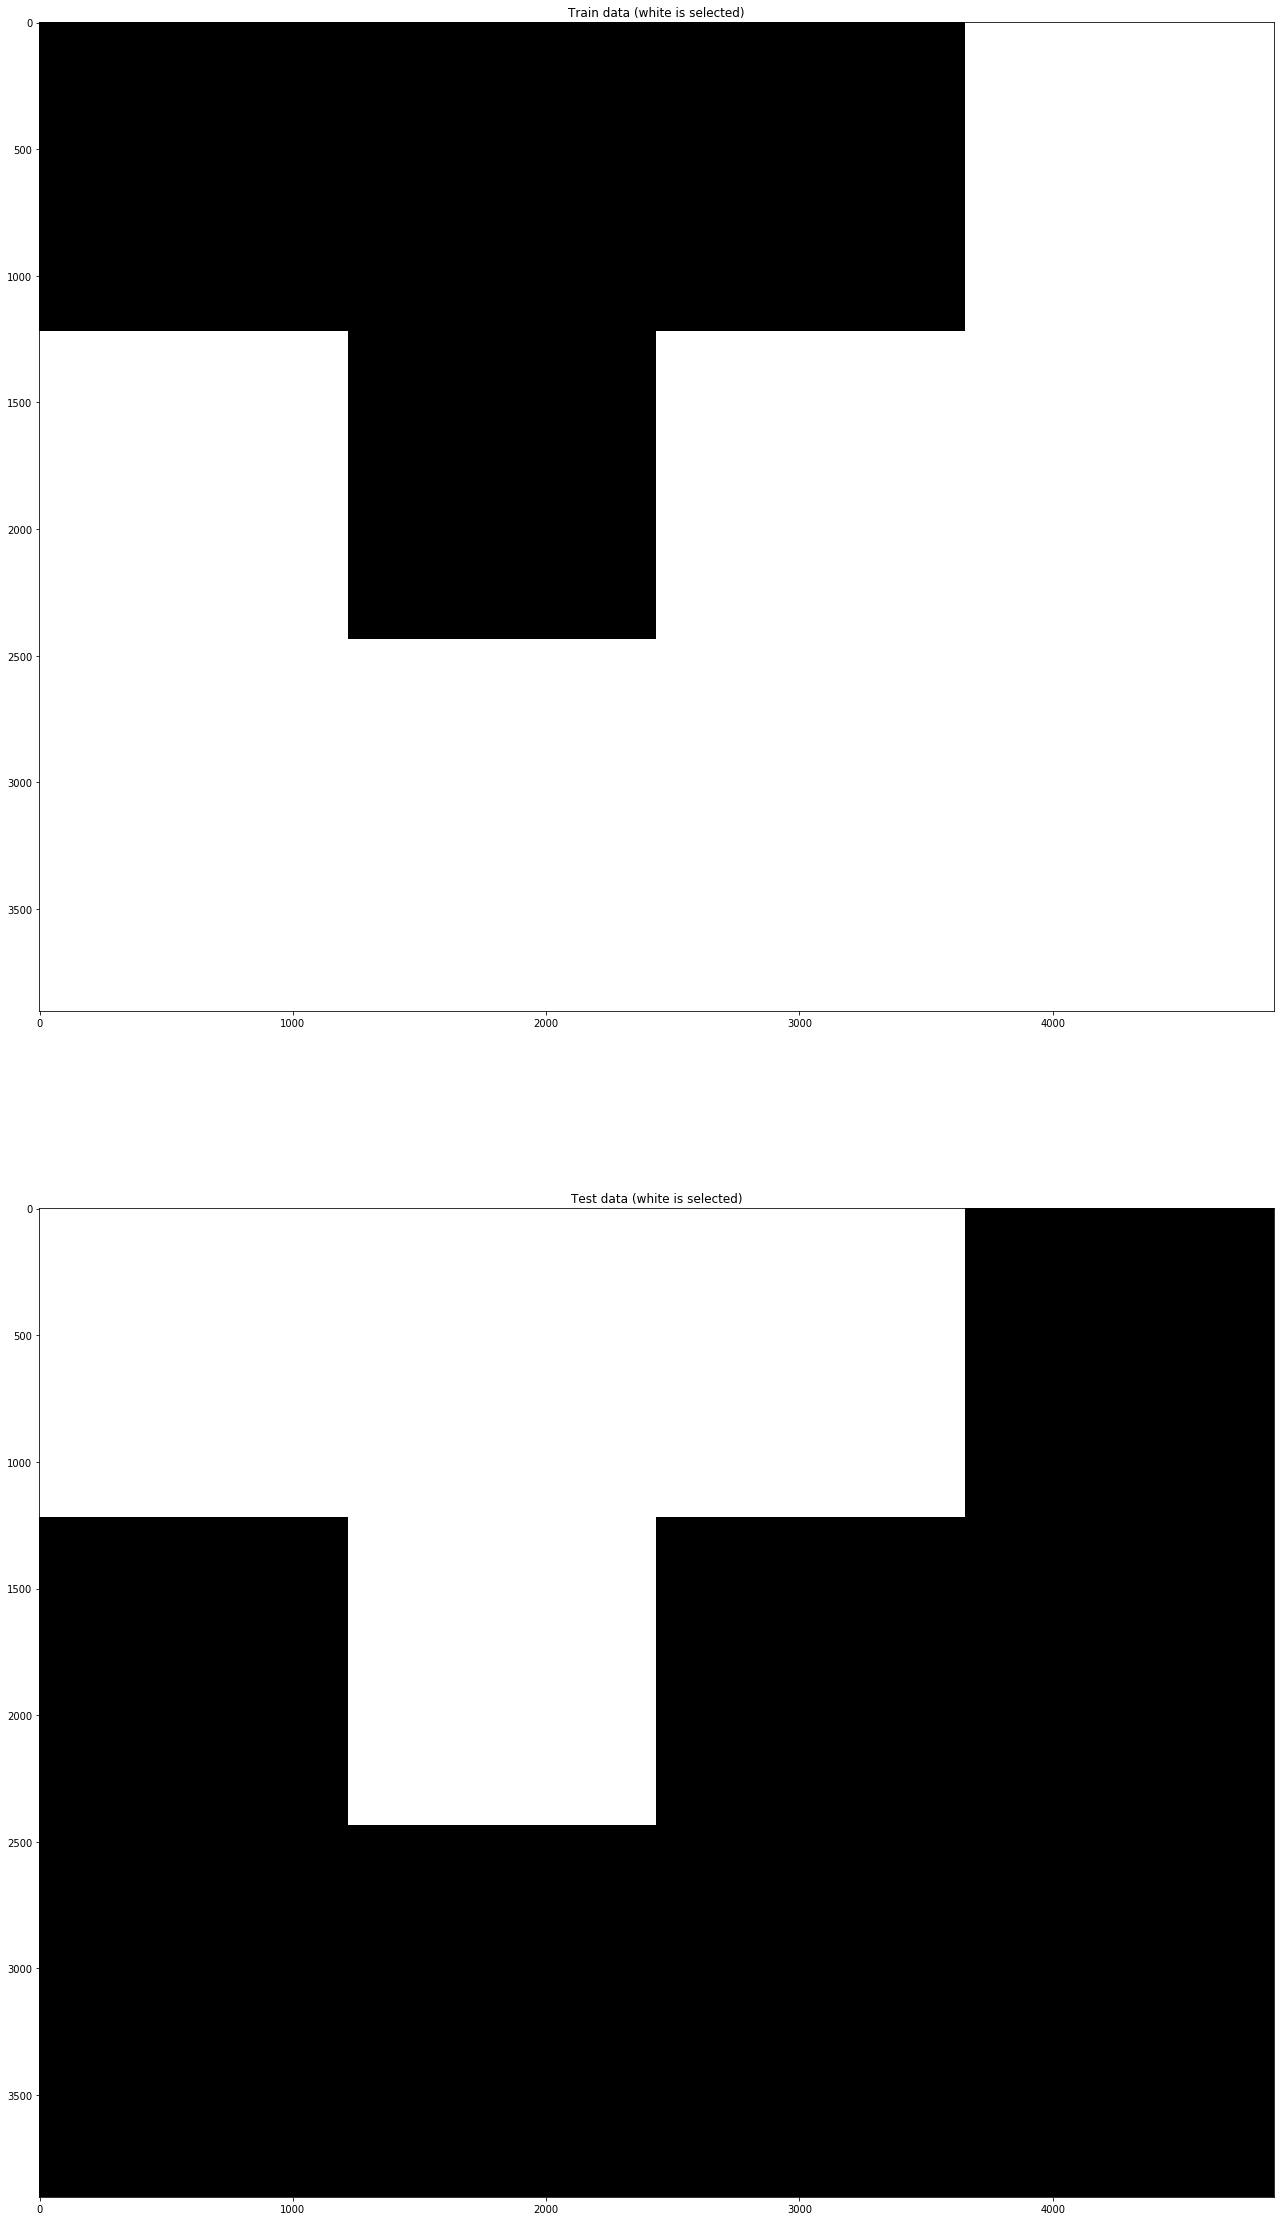

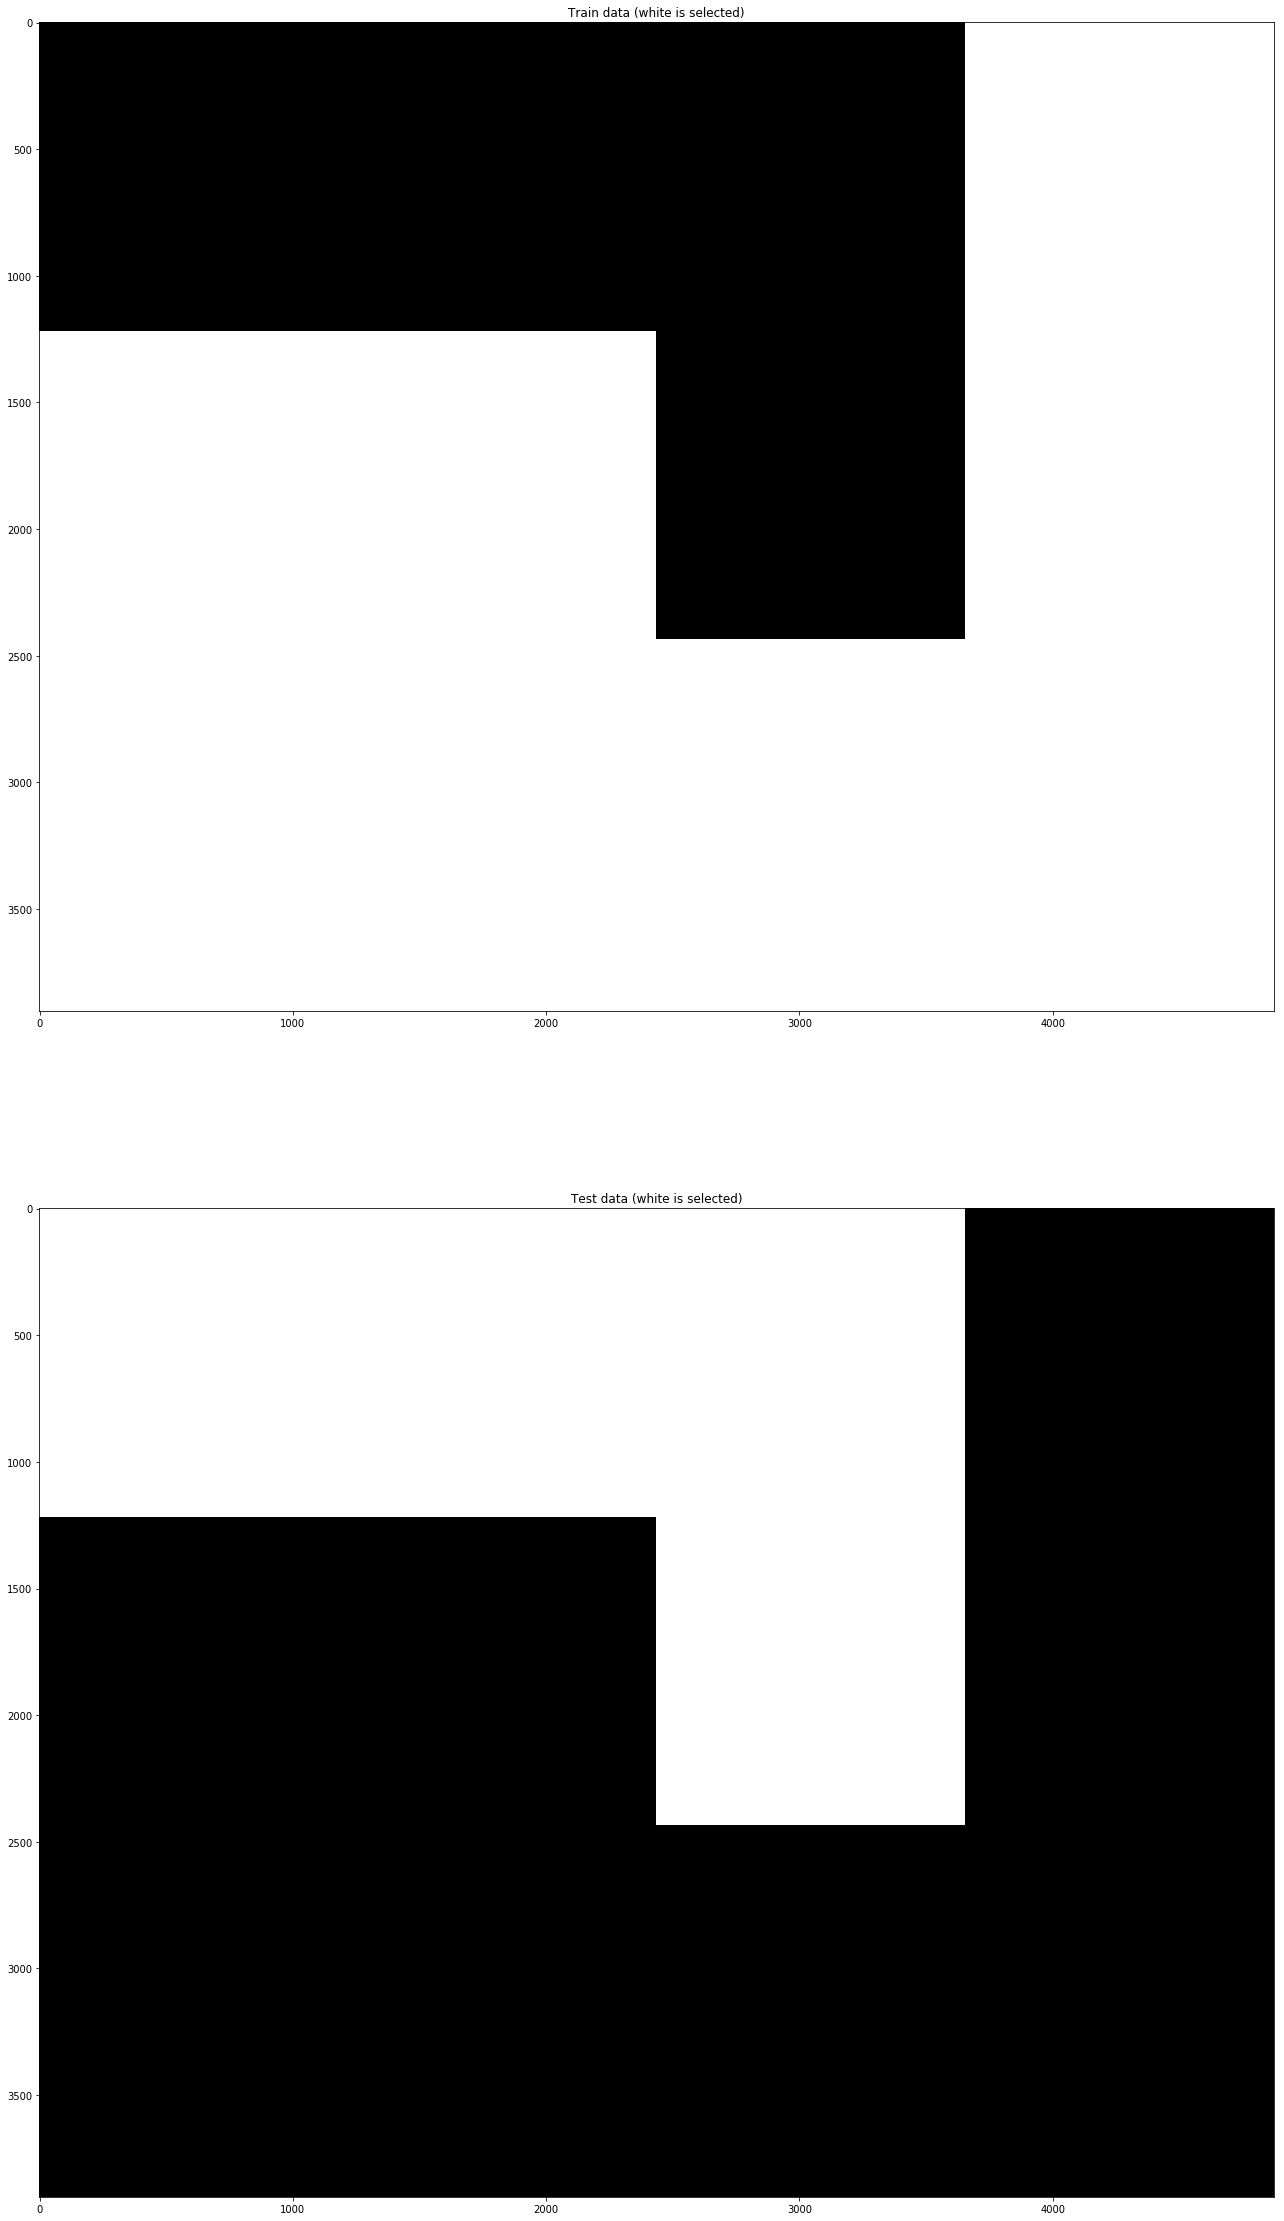

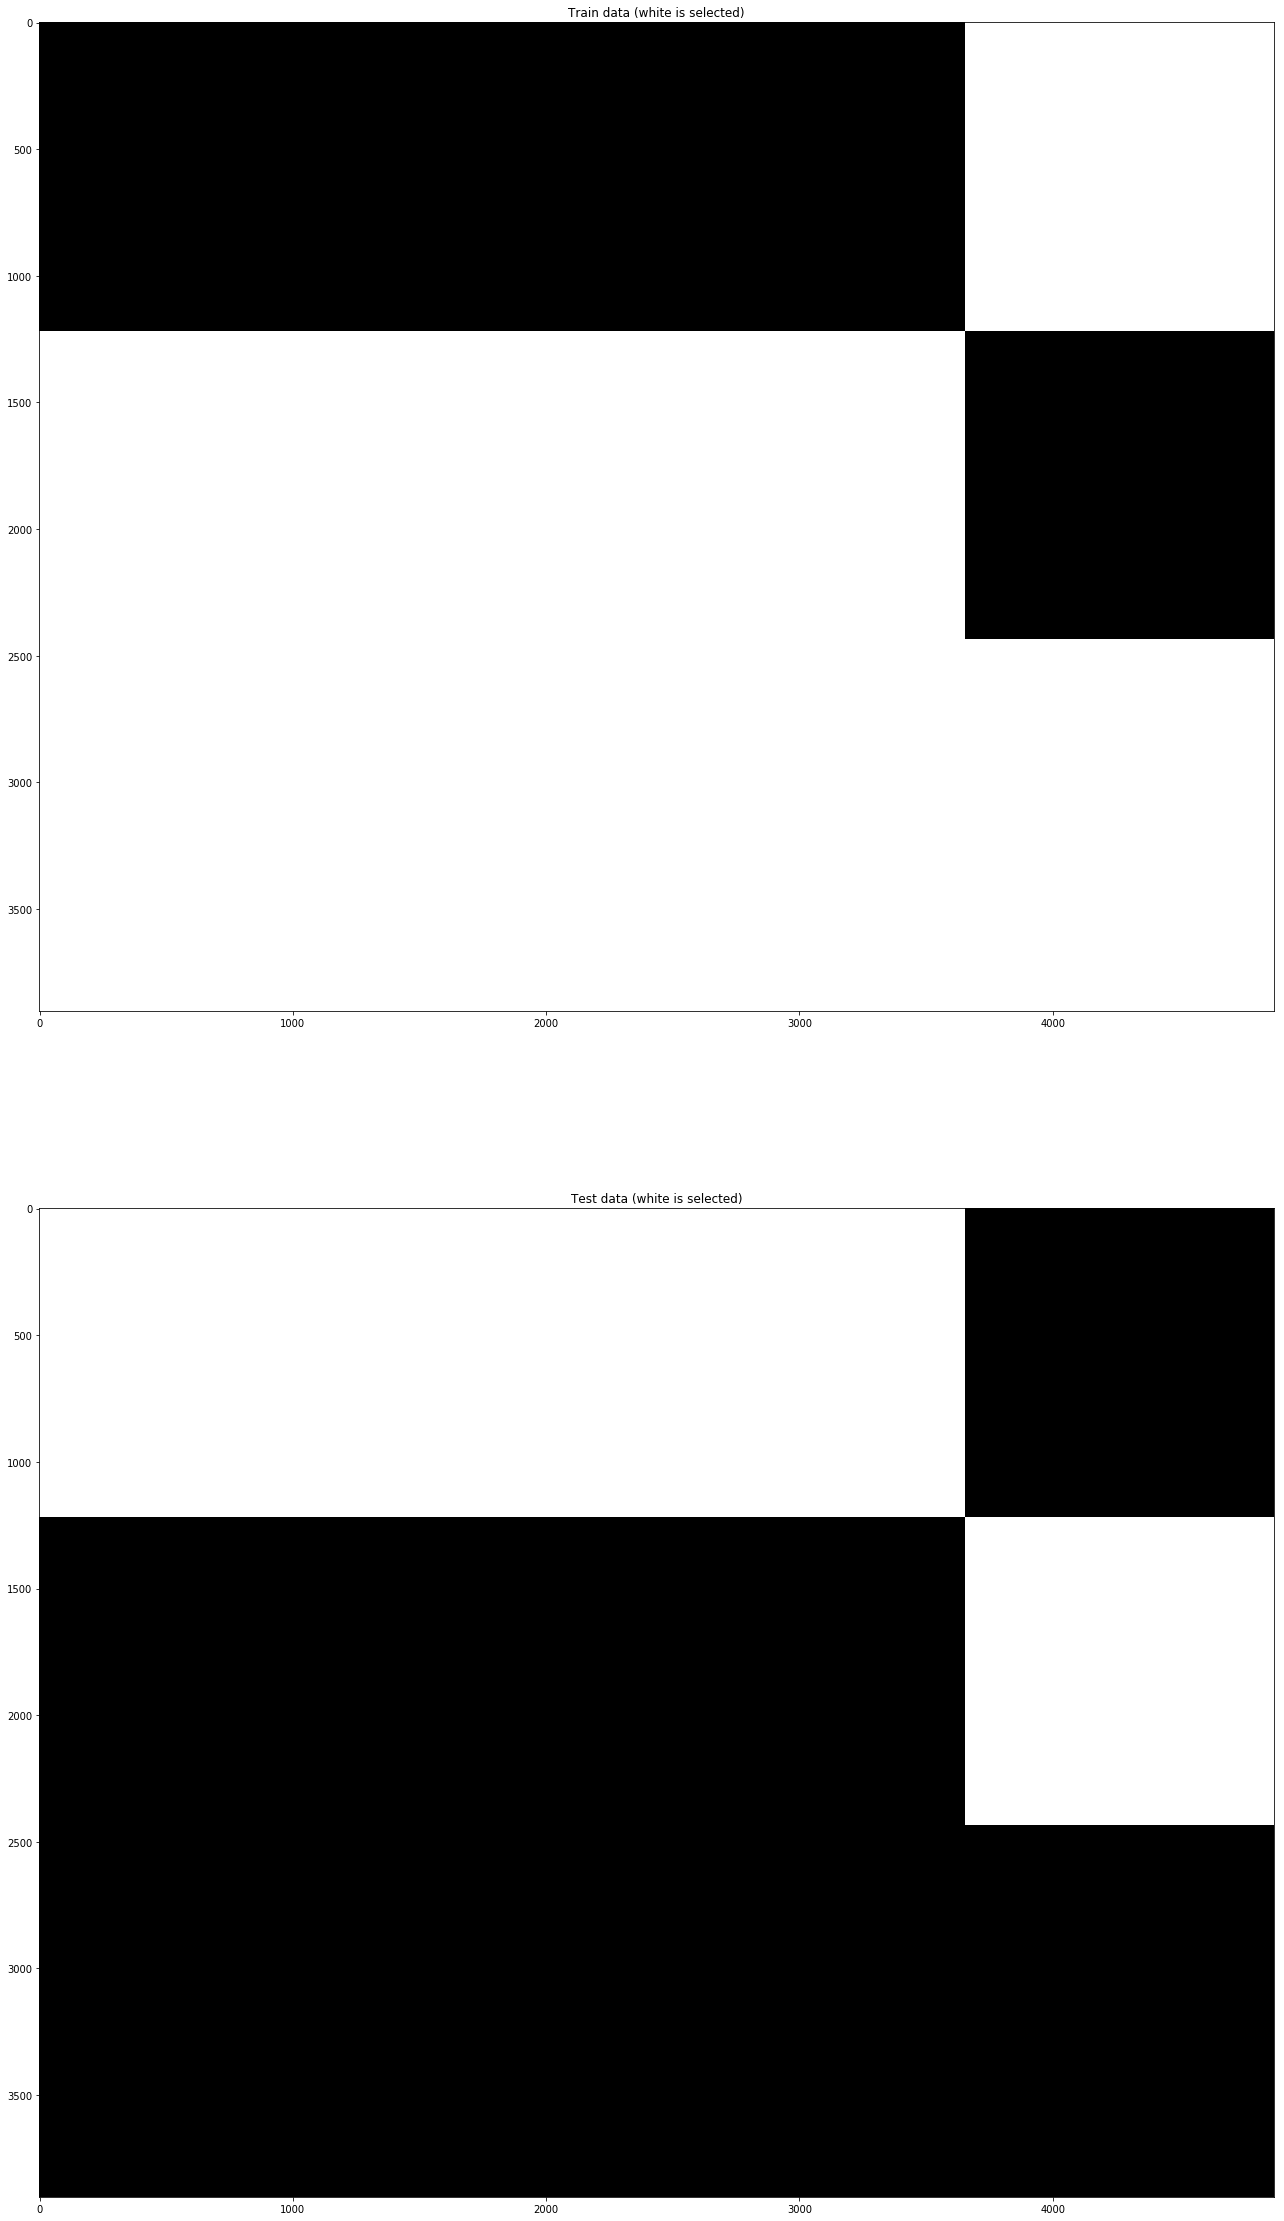

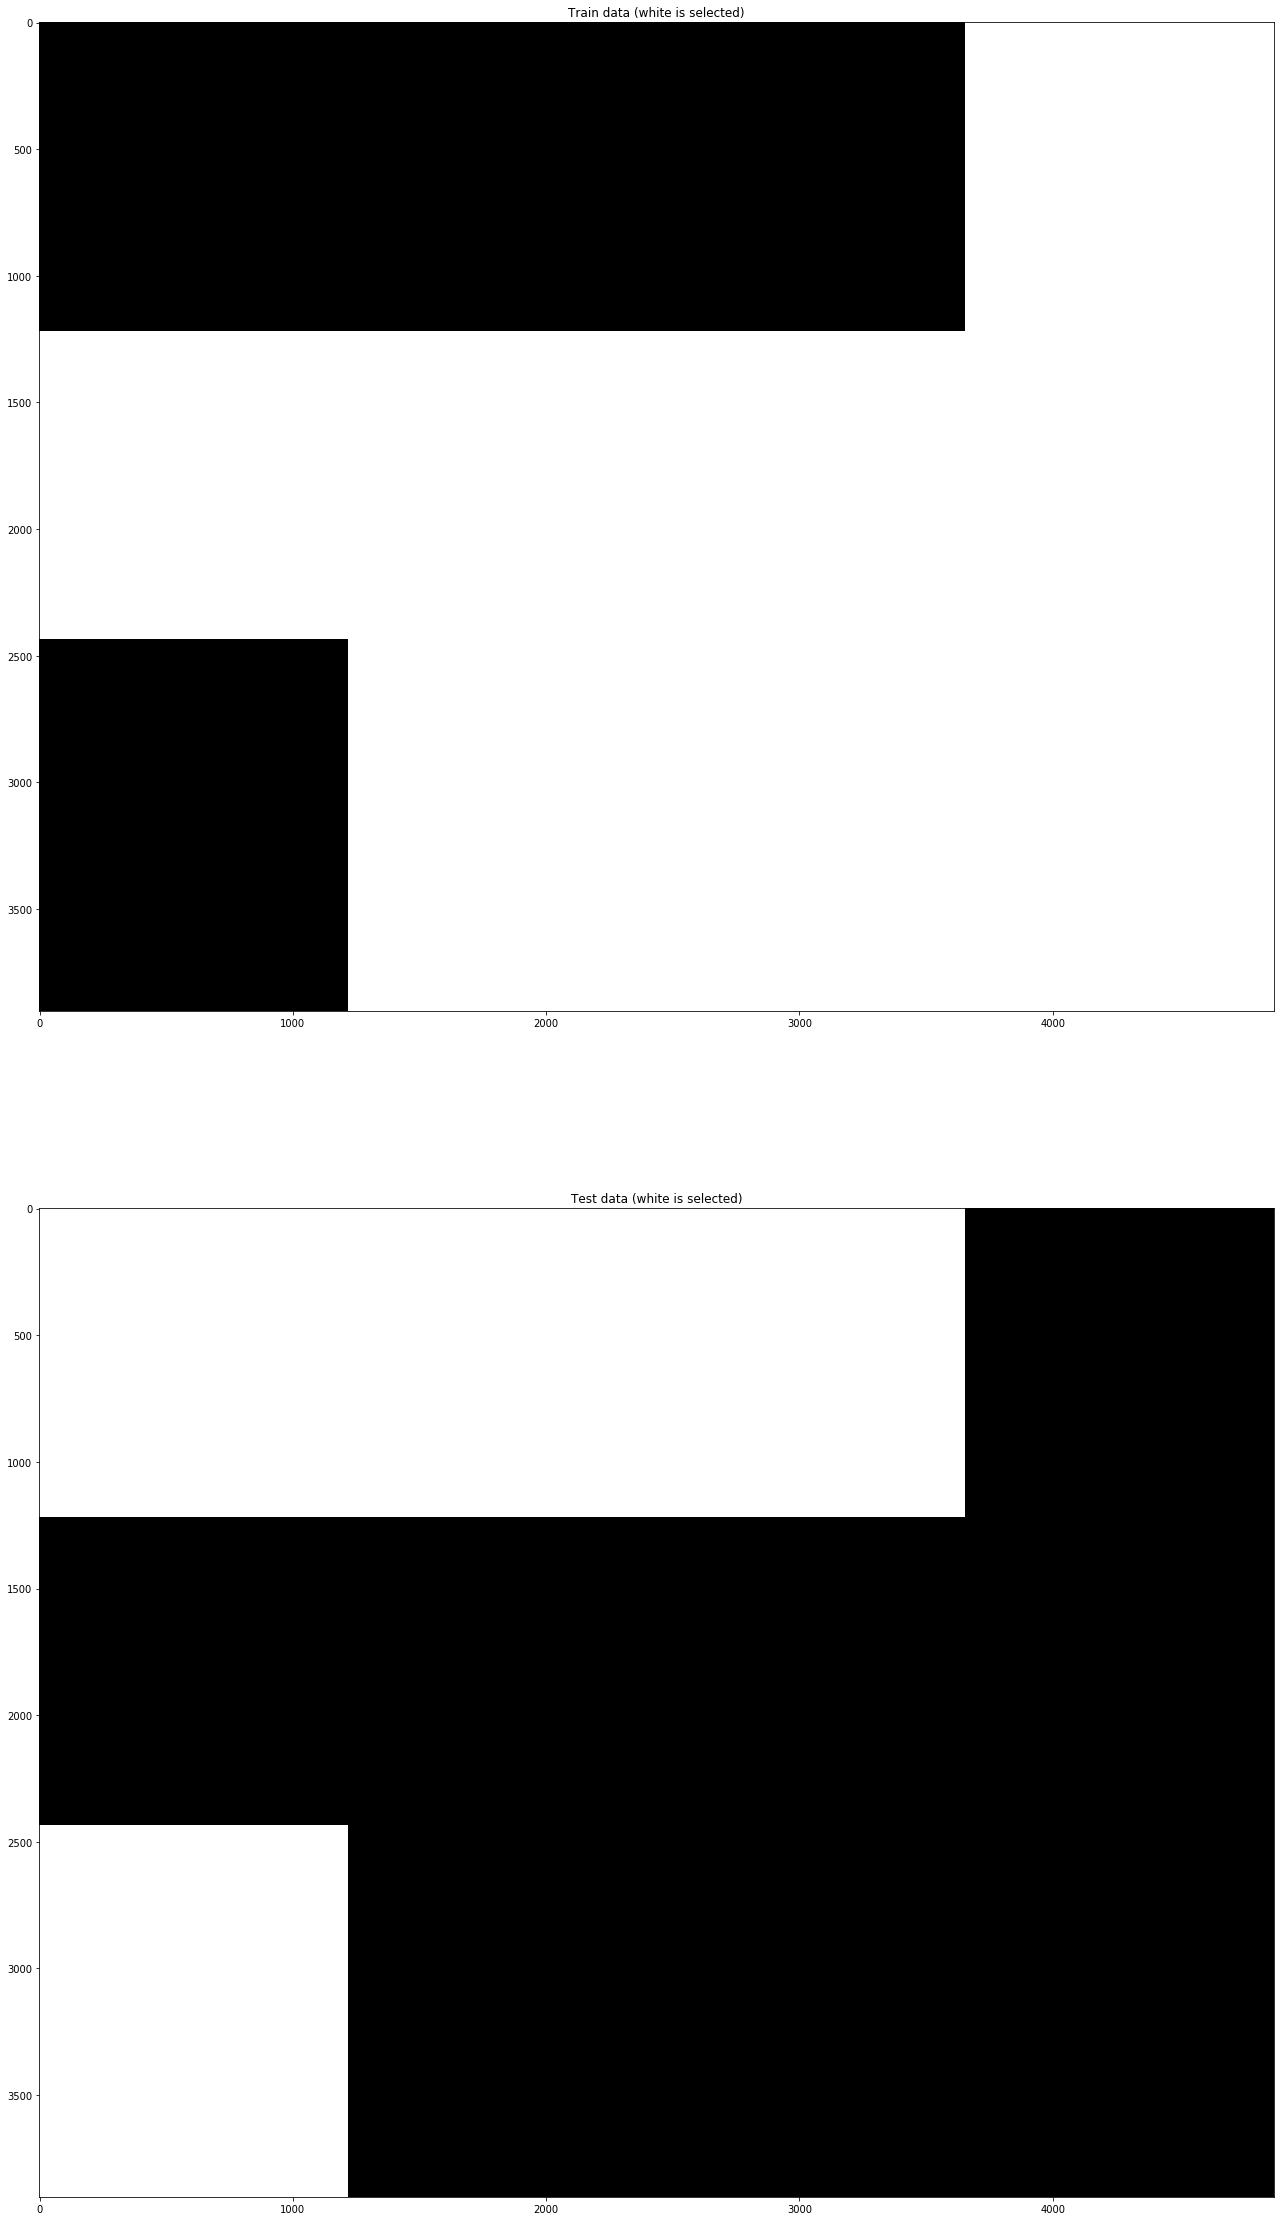

In [13]:
k = 0
for train_index, test_index in lpo.split(tileArray, yTileArray,groupArray):
#     print('train_index', train_index)
#     print('test_index', test_index)
    if k > 5: 
        break
        
    figure(figsize=(40,40))
    subplot(211)
    title('Train data (white is selected)')
    trainImg = zeros_like(labels)
    for idx in train_index:
        sy,ey,sx,ex, g = tileInfo[idx]
        trainImg[sy:ey,sx:ex] = 1
    imshow(trainImg,cmap='gray',vmax=1)
    subplot(212)
    title('Test data (white is selected)')
    testImg = zeros_like(labels)
    for idx in test_index:
        sy,ey,sx,ex, g = tileInfo[idx]
        testImg[sy:ey,sx:ex] = 1
    imshow(testImg,cmap='gray',vmax=1)
    k+=1

Now it's time to train our model.  For our convolutional neural network we're going to use a vanilla U-net and treat this as a semantic segmentation problem.

In [14]:
def model(trainTiles, yTiles):
    backend.clear_session()
    nb,h,w,c = trainTiles.shape
    nby,hy,wy,cy = yTiles.shape
    assert nb == nby
    assert h == hy
    assert w == wy
    
    i1 = Input((h,w,c))
    # 64x64
    c1 = Conv2D(32,3,padding='same',activation='relu')(i1)
    c1 = Conv2D(32,3,padding='same',activation='relu')(c1)
    p1 = MaxPooling2D()(c1)
    b1 = BatchNormalization()(p1)
    # 32x32
    c2 = Conv2D(64,3,padding='same',activation='relu')(b1)
    c2 = Conv2D(64,3,padding='same',activation='relu')(c2)
    p2 = MaxPooling2D()(c2)
    b2 = BatchNormalization()(p2)
    
    # 16x16
    c3 = Conv2D(128,3,padding='same',activation='relu')(b2)
    c3 = Conv2D(128,3,padding='same',activation='relu')(c3)
    p3 = MaxPooling2D()(c3)
    b3 = BatchNormalization()(p3)
    
    # 8x8
    c4 = Conv2D(256,3,padding='same',activation='relu')(b3)
    c4 = Conv2D(256,3,padding='same',activation='relu')(c4)
    p4 = MaxPooling2D()(c4)
    b4 = BatchNormalization()(p4)

    # 4x4
    c5 = Conv2D(512,3,padding='same',activation='relu')(b4)
    c5 = Conv2D(512,3,padding='same',activation='relu')(c5)
    
    # 8x8
    u4 = UpSampling2D()(c5)
    u4 = concatenate([c4,u4],axis=3)
    u4 = Conv2D(256,3,padding='same',activation='relu')(u4)
    u4 = Conv2D(256,3,padding='same',activation='relu')(u4)
    u4 = BatchNormalization()(u4)
    
    #16x16
    u3 = UpSampling2D()(u4)
    u3 = concatenate([c3,u3],axis=3)
    u3 = Conv2D(128,3,padding='same',activation='relu')(u3)
    u3 = Conv2D(128,3,padding='same',activation='relu')(u3)
    u3 = BatchNormalization()(u3)
    
    #32x32
    u2 = UpSampling2D()(u3)
    u2 = concatenate([c2,u2],axis=3)
    u2 = Conv2D(64,3,padding='same',activation='relu')(u2)
    u2 = Conv2D(64,3,padding='same',activation='relu')(u2)
    u2 = BatchNormalization()(u2)
    
    #64x64
    u1 = UpSampling2D()(u2)
    u1 = concatenate([c1,u1],axis=3)
    u1 = Conv2D(32,3,padding='same',activation='relu')(u1)
    u1 = Conv2D(32,3,padding='same',activation='relu')(u1)
    u1 = BatchNormalization()(u1)
    
    o1 = Conv2D(16, 3, padding='same',activation='relu')(u1)
    o1 = Conv2D(cy, 1, padding='same',activation='softmax')(o1)
    
    return Model(input=[i1], outputs=[o1])




In [70]:
def lr(x, y):
    return x[:,::-1,:], y[:,::-1,:]
def ud(x,y):
    return x[::-1,:,:], y[::-1,:,:]
def udlr(x,y):
    return ud(*lr(x,y))
def ident(x,y):
    return x,y

def augmentGenerator(x,y,batchSize,augment=True):
    # we have to use a generator function here because augmenting the raw data results in memory errors
    # essentially you wind up with multiple copies of a 13000,64,64,20 array floating around, which is at least 4GB
    # i think this has something to do with Jupyter holding onto variables beyond their normally expected lifespan, but
    # i would have to debug this further to figure it out for sure.
    b, h,w,c = x.shape
    _, _, _, yc = y.shape
    out_x = np.zeros((batchSize,h,w,c))
    out_y = np.zeros((batchSize,h,w,yc))
    funcs = [ident,lr,ud,udlr] if augment else [ident]
    
    idx = np.arange(0,b*len(funcs))
    print('len.idx', len(idx))
    while True:
        np.random.shuffle(idx)
        
        for k in range(0,len(idx),batchSize):
            if k + batchSize > len(idx):
                break
            out_x.fill(0)
            out_y.fill(0)
            group_idx = idx[k:k+batchSize]
            
            didx = group_idx % b
            fidx = group_idx // b
            for j in range(batchSize):
                func = funcs[fidx[j]]
                ax,ay = func(x[didx[j]],y[didx[j]])
                out_x[j] = ax
                out_y[j] = ay
#             bx = x[group_idx]
#             by = y[group_idx]
#             for j,func in enumerate(funcs):
#                 ax,ay = func(bx,by)
#                 out_x[j*ng:(j+1)*ng] = ax
#                 out_y[j*ng:(j+1)*ng] = ay
            yield np.array(out_x), np.array(out_y)
    
def makeGenerators(x,y,batchSize,train_size=0.9):
    xtrain,xval,ytrain,yval = train_test_split(x,y,train_size=train_size)
    train_gen = augmentGenerator(xtrain,ytrain,batchSize)
    val_gen   = augmentGenerator(xval,yval,batchSize,augment=False)
    return train_gen, val_gen

The summary of the model below shows the model schema.

In [44]:
m = model(tileArray, yTileArray)    

m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 20)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   5792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


To start we're going to use the naive random sampling approach and show what happens
with training and test validation. 

In [27]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(tileArray,yTileArray,train_size=0.5)

In [28]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((2520, 64, 64, 20),
 (2520, 64, 64, 20),
 (2520, 64, 64, 10),
 (2520, 64, 64, 10))

Do some basic augmentation here to help out a bit.

In [63]:
batchSize = 128
train_gen, val_gen = makeGenerators(xtrain,ytrain,batchSize)

In [64]:
# these are just some basic choices, with more time we could investigate more options
m.compile(Adam(lr=1e-4),metrics=['accuracy'],loss='categorical_crossentropy')

In [65]:
m.fit_generator(train_gen, steps_per_epoch=xtrain.shape[0]*4//batchSize, epochs=10, verbose=1, validation_data=val_gen, validation_steps=5, max_queue_size=25)

Epoch 1/10
len.idx 10080
len.idx 2520
78/78 [==============================] - 48s 613ms/step - loss: 1.4538 - acc: 0.5715 - val_loss: 1.1558 - val_acc: 0.6748
Epoch 2/10
78/78 [==============================] - 37s 470ms/step - loss: 1.0220 - acc: 0.6996 - val_loss: 0.9989 - val_acc: 0.7024
Epoch 3/10
78/78 [==============================] - 37s 472ms/step - loss: 0.9012 - acc: 0.7245 - val_loss: 0.9761 - val_acc: 0.6942
Epoch 4/10
78/78 [==============================] - 37s 471ms/step - loss: 0.8253 - acc: 0.7410 - val_loss: 0.9169 - val_acc: 0.7237
Epoch 5/10
78/78 [==============================] - 37s 473ms/step - loss: 0.7702 - acc: 0.7508 - val_loss: 0.8910 - val_acc: 0.7238
Epoch 6/10
78/78 [==============================] - 37s 473ms/step - loss: 0.7252 - acc: 0.7630 - val_loss: 0.8189 - val_acc: 0.7313
Epoch 7/10
78/78 [==============================] - 37s 475ms/step - loss: 0.6835 - acc: 0.7720 - val_loss: 0.8171 - val_acc: 0.7312
Epoch 8/10
78/78 [========================

Normally, we'd let this run for a longer time and use early stopping to prevent overfitting, but since we don't want to consume a lot of resources right now we'll let it stop after 10 epochs, even at the risk of underfitting.

In [66]:
predictions = m.predict(tileArray)
results = np.zeros_like(labels)
for k, predictionTile in enumerate(predictions):
    sy,ey,sx,ex,g = tileInfo[k]
    results[sy:ey,sx:ex] = np.argmax(predictionTile,axis=2)

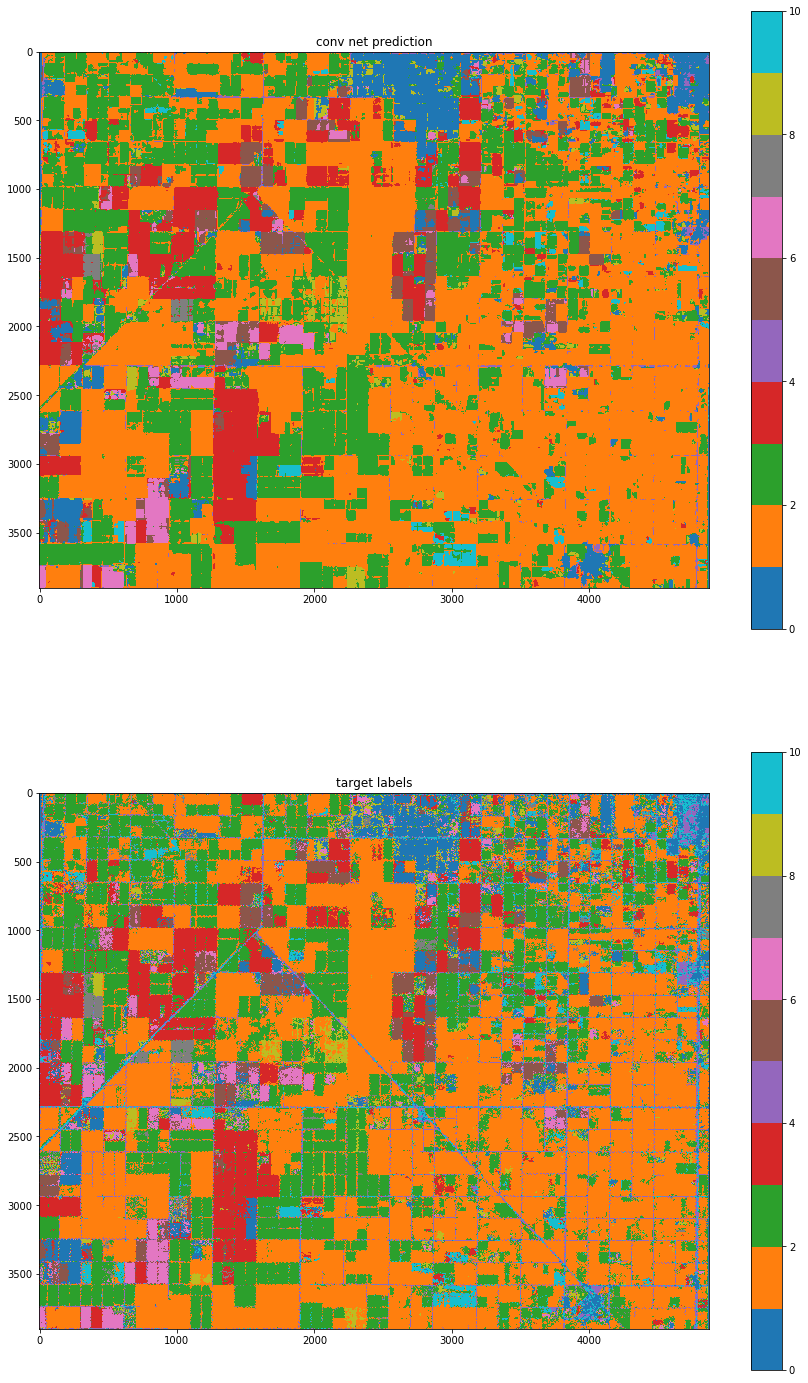

In [67]:
figure(figsize=(15,25))

subplot(211)
title('conv net prediction')
imshow(results,cmap='tab10',vmax=10)
colorbar()
subplot(212)
title('target labels')
imshow(labels,cmap='tab10',vmax=10)
colorbar()
savefig('raw_conv.png')

We split the data into 50/50 train and validation split, and we get a pretty decent result, but we can clearly see that the biggest difference between the two images is that it looks like the predicted image is smoothed relative to the right image.  However, it has made some of the predicted labels more contiguous relative to what we see in the raw labels, and picked out some areas that look more reasonable to me that what we see in the raw data.

In [68]:
import stats
print(stats.prf1_score_img(labels, results))

      Recall  Precision        F1  Support
0   0.608897   0.644966  0.626413  1141647
1   0.821104   0.919458  0.867502  8300189
2   0.768481   0.812564  0.789908  4721173
3   0.803243   0.838157  0.820329  1540735
4   0.406350   0.119031  0.184127   754481
5   0.707345   0.724010  0.715581   615181
6   0.621712   0.492624  0.549691   490124
7   0.657880   0.108087  0.185670   409151
8   0.389368   0.338505  0.362159   378777
9   0.559443   0.453447  0.500899   339901
10  0.000000   0.000000  0.000000   323087


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Unfortunately because there is so much noise in the target labels the P-R and F1 stats don't look very good, but I'm not super concerned about the inability to quantify how good the results are here.  Ultimately, I'd have to know more about how "good" the target labels are in order to say if we should be matching them better.

Comparing these results to those we obtained from the Random Forest Classifier in the Feature Selection section, we see that these results are actually pretty comparable, and in most cases better.  Keep in mind though, that the conv net has seen significantly more data points than the RFC, so if the RFC was given enough data it might do better.

Now we run the true held out test, where we hold out entire groups of data from the model during the training phase, and then predict only on those groups. This should give us a much better idea of how well it will predict on new areas.

In [71]:
def fitData(train_index):
    xt = tileArray[train_index]
    yt = yTileArray[train_index]
    train_gen, val_gen = makeGenerators(xt,yt, 128)
    temp_model = model(xt,yt)
    temp_model.compile(Adam(lr=1e-4),metrics=['accuracy'],loss='categorical_crossentropy')
    # normally I'd use early stopping but 10 epochs seems to be about right
    temp_model.fit_generator(train_gen, steps_per_epoch=xtrain.shape[0]*4//batchSize, epochs=10, verbose=1, 
                             validation_data=val_gen, validation_steps=5, max_queue_size=25)
    return temp_model

nExamples = 0
kPermutation = 0
predictionImage = []

for train_index, test_index in lpo.split(tileArray, yTileArray,groupArray):
    kPermutation += 1
    
    if kPermutation % 10 != 0:
        continue
        
    if nExamples > 3:
        break
        
    temp_model = fitData(train_index)
    
    predictions = temp_model.predict(tileArray[test_index])
    results = np.zeros_like(labels)
    mask    = np.zeros(labels.shape,dtype='bool')
    
    prediction_groups = set()
    for k, predictionTile in enumerate(predictions):
        sy,ey,sx,ex,g = tileInfo[test_index[k]]
        prediction_groups.add(g)
        results[sy:ey,sx:ex] = np.argmax(predictionTile,axis=2)
        mask[sy:ey,sx:ex] = 1

    f = figure(figsize=(40,40))
    f.set_tight_layout(True)
    nrows = len(prediction_groups)
    for k, prediction_group in enumerate(prediction_groups):
        sy,ey, sx, ex = groupMap[prediction_group]
        subplot(nrows,2,2*k+1)
        imshow(results[sy:ey,sx:ex],cmap='tab10')
        ylabel('group: {0}'.format(prediction_group))
        subplot(nrows,2,2*k+2)
        imshow(labels[sy:ey,sx:ex],cmap='tab10')

    f.savefig('conv_heldout_example_{:02d}.png'.format(nExamples))
    print('**** Summary stats for Example: {} ****'.format(nExamples))
    print(stats.prf1_score_img(labels[mask],results[mask]))
    
    close(f)
    predictions = None
    del predictions
    predictionImage.append(results)
    nExamples+=1
    

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


Epoch 1/10
len.idx 344
len.idx 12384
78/78 [==============================] - 43s 550ms/step - loss: 1.3772 - acc: 0.5901 - val_loss: 1.2354 - val_acc: 0.6723
Epoch 2/10
78/78 [==============================] - 37s 468ms/step - loss: 0.9706 - acc: 0.7123 - val_loss: 1.0722 - val_acc: 0.6863
Epoch 3/10
78/78 [==============================] - 37s 472ms/step - loss: 0.8588 - acc: 0.7327 - val_loss: 0.9483 - val_acc: 0.7009
Epoch 4/10
78/78 [==============================] - 37s 469ms/step - loss: 0.7941 - acc: 0.7460 - val_loss: 0.8405 - val_acc: 0.7175
Epoch 5/10
78/78 [==============================] - 37s 474ms/step - loss: 0.7422 - acc: 0.7597 - val_loss: 0.8923 - val_acc: 0.7164
Epoch 6/10
78/78 [==============================] - 37s 475ms/step - loss: 0.6964 - acc: 0.7712 - val_loss: 0.8257 - val_acc: 0.7351
Epoch 7/10
78/78 [==============================] - 37s 471ms/step - loss: 0.6592 - acc: 0.7818 - val_loss: 0.7674 - val_acc: 0.7489
Epoch 8/10
78/78 [=========================

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Recall  Precision        F1  Support
0   0.386600   0.547831  0.453306   371885
1   0.661787   0.774135  0.713566  1904152
2   0.655297   0.717344  0.684918  1725345
3   0.687919   0.648026  0.667377   770792
4   0.235429   0.264517  0.249127   238223
5   0.646948   0.264315  0.375299   204733
6   0.379122   0.319587  0.346818   167028
7   0.148652   0.003066  0.006008   188856
8   0.097900   0.020683  0.034151   102789
9   0.159296   0.063218  0.090515   121990
10  0.000000   0.000000  0.000000   139521
Epoch 1/10
len.idx 344
len.idx 12384
78/78 [==============================] - 43s 552ms/step - loss: 1.3502 - acc: 0.5810 - val_loss: 1.0464 - val_acc: 0.6677
Epoch 2/10
78/78 [==============================] - 37s 474ms/step - loss: 0.9724 - acc: 0.6963 - val_loss: 0.9288 - val_acc: 0.7030
Epoch 3/10
78/78 [==============================] - 37s 475ms/step - loss: 0.8812 - acc: 0.7186 - val_loss: 0.8440 - val_acc: 0.7388
Epoch 4/10
78/78 [==============================] - 37s 476

## Results
Shown below are comparisons of the predictions versus the ground truth for the heldout tiles for the various permutations selected. In all cases, the left side shows the predictions, and the right side shows the ground truth. 

I think overall the image comparisons are pretty interesting. In some cases, the ground truth and the predictions line up very well. In other cases, it looks like the predicted classes are kind of switching to a class that the ground truth hints could be there, but does not necessarily show as the dominant class in an area. In yet other locations, it looks like the predicted class is very different from the ground truth. I'd like to investigate some of these areas more in detail to determine how well we are doing.  It's also interesting to observe that the predicted classes tend to show significantly more detail than the ground truth. This is probably an artifact of the upsampling procedure used to match the resolution between the USDA labels and the satellite imagery.  Overall, I'd need some more time to do a deep dive on the predictions here to see if they make sense in areas where there are big disagreements between the predicted class and the USDA labels, but all in all these results look pretty promising and are showing that this approach generalizes well to entirely unseen areas of the dataset. 

Another observation worth mentioning is that as I expected, the summary statistics for each example (wherein we change the tiles held out from the training dataset) show that our overall ability to make accurate predictions fluctuates a bit depending on which tiles are held out, but does not drastically change for the well sampled classes. For classes with few samples in the image, changing which tiles are held out can have a huge impact on our ability to make good predictions (which is expected).

## Example 0
![](conv_heldout_example_00.png)
## Example 1
![](conv_heldout_example_01.png)
## Example 2
![](conv_heldout_example_02.png)
## Example 3
![](conv_heldout_example_03.png)